In [1]:
!ls

datalab


### Install/Download Essentials

In [0]:
%%capture
!wget https://github.com/shaoanlu/faceswap-GAN/raw/master/instance_normalization.py
!wget https://github.com/shaoanlu/GroupNormalization-keras/raw/master/GroupNormalization.py

In [0]:
#%%capture
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
#!pip install keras

In [0]:
#%%capture
#!pip install Augmentor

<a id='1'></a>
###  Import packages

In [1]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.applications import *
import keras.backend as K
from tensorflow.contrib.distributions import Beta
import tensorflow as tf
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
from instance_normalization import InstanceNormalization
from GroupNormalization import GroupNormalization

In [0]:
import time
import numpy as np
import glob
from IPython.display import clear_output
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import Augmentor

In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12626724653558355217, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
 }
 incarnation: 2744610880821168650
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

<a id='4'></a>
### Config

In [0]:
K.set_learning_phase(1)

In [0]:
channel_axis=-1
channel_first = False

In [0]:
IMAGE_SHAPE = (128, 128, 3)
nc_in = 3 # number of input channels of generators
nc_D_inp = 3 # number of input channels of discriminators
n_dim_style = 8
n_resblocks = 3 # number of residual blocks in decoder
n_adain = 2*n_resblocks
n_dim_adain = 256

nc_base = 64 # Number of channels of the first conv2d of encoder
n_downscale_content = 2 # Number of content encoder dowscaling
n_dowscale_style = 4 # Number of style encoder dowscaling

use_perceptual_loss = True
use_lsgan = True
use_mixup = True
mixup_alpha = 0.2 # 0.2

batchSize = 1 # 8
lrD = 1e-4 # Discriminator learning rate
lrG = 1e-4 # Generator learning rate

# Path of training images
img_dirA = 'train/edge/*.*'
img_dirB = 'train/shoes/*.*'

<a id='5'></a>
# 5. Define models

In [0]:
conv_init = RandomNormal(0, 0.02)

In [0]:
##################################################################################
# Basic Blocks
##################################################################################
def conv_block(input_tensor, f, k=3, strides=2, use_norm=False):
    x = input_tensor
    x = Conv2D(f, kernel_size=k, strides=strides, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
    if use_norm:
        x = InstanceNormalization()(x)
    x = Activation("relu")(x)
    return x

def conv_block_d(input_tensor, f, use_instance_norm=True):
    x = input_tensor
    x = Conv2D(f, kernel_size=4, strides=2, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def upscale_nn(inp, f, use_norm=False):
    x = inp
    x = UpSampling2D()(x)
    x = Conv2D(f, kernel_size=5, use_bias=True, padding='same')(x)
    if use_norm:
        x = GroupNormalization(group=8)(x)
    x = Activation('relu')(x)
    return x
  
def ReflectPadding2D(x, pad=1):
    x = Lambda(lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode='REFLECT'))(x)
    return x

##################################################################################
# Discriminators
##################################################################################
def Discriminator(nc_in, input_size=IMAGE_SHAPE[0]):
    inp = Input(shape=(input_size, input_size, nc_in))
    x = conv_block_d(inp, 64, False)
    x = conv_block_d(x, 128, False)
    x = conv_block_d(x, 256, False)
    out = Conv2D(1, kernel_size=4, kernel_initializer=conv_init, use_bias=False, padding="same", activation="sigmoid")(x)   
    return Model(inputs=[inp], outputs=out)

def Discriminator_MS(nc_in, input_size=IMAGE_SHAPE[0]):
    # Multi-scale discriminator architecture, inspired from pix2pixHD
    # https://arxiv.org/abs/1711.11585
    inp = Input(shape=(input_size, input_size, nc_in))
    
    def conv2d_blocks(inp, nc_base=64, n_layers=3):
        x = inp
        dim = nc_base
        for _ in range(n_layers):
            x = conv_block_d(x, dim, False)
            dim *= 2
        x = Conv2D(1, kernel_size=4, kernel_initializer=conv_init, use_bias=True, padding="same", activation="sigmoid")(x)
        return x
    
    x0 = conv2d_blocks(inp)    
    ds1 = AveragePooling2D(pool_size=(3, 3), strides=2)(inp)
    x1 = conv2d_blocks(ds1)
    ds2 = AveragePooling2D(pool_size=(3, 3), strides=2)(ds1)
    x2 = conv2d_blocks(ds2)
    return Model(inputs=[inp], outputs=[x0, x1, x2])

##################################################################################
# MUNIT Model Architecture, Encoder
##################################################################################    
def Encoder_style_MUNIT(nc_in=3, input_size=IMAGE_SHAPE[0], n_dim_adain=256, n_dim_style=n_dim_style, nc_base=nc_base, n_dowscale_style=n_dowscale_style):
    # Style encoder architecture 
    inp = Input(shape=(input_size, input_size, nc_in))
    x = Conv2D(64, kernel_size=5, kernel_initializer=conv_init, use_bias=True, padding="same")(inp)
    dim = 1
    for i in range(n_dowscale_style):
        dim = 4 if dim >= 4 else dim*2
        x = conv_block(x, dim*nc_base)
    x = GlobalAveragePooling2D()(x)    
    style_code = Dense(n_dim_style)(x) # Style code
    return Model(inp, style_code)

def Encoder_content_MUNIT(nc_in=3, input_size=IMAGE_SHAPE[0], n_downscale_content=n_downscale_content, nc_base=nc_base):
    # Content encoder architecture 
    def res_block_content(input_tensor, f):
        x = input_tensor
        x = Conv2D(f, kernel_size=3, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
        x = InstanceNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(f, kernel_size=3, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
        x = InstanceNormalization()(x)
        x = add([x, input_tensor])
        return x      
    
    inp = Input(shape=(input_size, input_size, nc_in))
    x = Conv2D(64, kernel_size=5, kernel_initializer=conv_init, use_bias=True, padding="same")(inp)
    dim = 1
    ds = 2**n_downscale_content
    for i in range(n_downscale_content):
        dim = 4 if dim >= 4 else dim*2
        x = conv_block(x, dim*nc_base, use_norm=True)
    x = res_block_content(x, dim*nc_base)
    x = res_block_content(x, dim*nc_base) 
    x = res_block_content(x, dim*nc_base)    
    content_code = x # Content code
    return Model(inp, content_code)

##################################################################################
# MUNIT Model Architecture, Decoder
##################################################################################  
def MLP_MUNIT(n_dim_style=n_dim_style, n_dim_adain=n_dim_adain, n_blk=3, n_adain=2*n_resblocks):
    # MLP for AdaIN parameters
    inp_style_code = Input(shape=(n_dim_style,))
    
    adain_params = Dense(n_dim_adain, activation='relu')(inp_style_code)
    for i in range(n_blk - 2):
        adain_params = Dense(n_dim_adain, activation='relu')(adain_params)
    adain_params = Dense(2*n_adain*n_dim_adain)(adain_params) # No output activation 
    return Model(inp_style_code, [adain_params])
  
def Decoder_MUNIT(nc_in=256, input_size=IMAGE_SHAPE[0]//(2**n_downscale_content), n_dim_adain=256, n_resblocks=n_resblocks):
    def op_adain(inp):
        x = inp[0]
        mean, var = tf.nn.moments(x, [1,2], keep_dims=True)
        adain_bias = inp[1]
        adain_bias = K.reshape(adain_bias, (-1, 1, 1, n_dim_adain))
        adain_weight = inp[2]
        adain_weight = K.reshape(adain_weight, (-1, 1, 1, n_dim_adain))        
        out = tf.nn.batch_normalization(x, mean, var, adain_bias, adain_weight, variance_epsilon=1e-7)
        return out
      
    def AdaptiveInstanceNorm2d(inp, adain_params, idx_adain):
        assert inp.shape[-1] == n_dim_adain
        x = inp
        idx_head = idx_adain*2*n_dim_adain
        adain_weight = Lambda(lambda x: x[:, idx_head:idx_head+n_dim_adain])(adain_params)
        adain_bias = Lambda(lambda x: x[:, idx_head+n_dim_adain:idx_head+2*n_dim_adain])(adain_params)
        out = Lambda(op_adain)([x, adain_bias, adain_weight])
        return out
      
    def res_block_adain(inp, f, adain_params, idx_adain):
        x = inp
        x = Conv2D(f, kernel_size=3, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
        x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain))([x, adain_params])     
        x = Activation('relu')(x)
        x = Conv2D(f, kernel_size=3, kernel_initializer=conv_init, use_bias=True, padding="same")(x)
        x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain+1))([x, adain_params])    
        
        x = add([x, inp])
        return x  
    
    inp_style = Input((n_dim_style,))
    style_code = inp_style
    mlp = MLP_MUNIT()
    adain_params = mlp(style_code)
    
    inp_content = Input(shape=(input_size, input_size, nc_in))
    content_code = inp_content
    x = inp_content
    
    for i in range(n_resblocks):
        x = res_block_adain(x, nc_in, adain_params, 2*i) 
        
    dim = 1
    for i in range(n_downscale_content):
        dim = dim if nc_in//dim <= 64 else dim*2
        # Note: original MUNIT uses layer norm instead of group norm in upscale blocks
        x = upscale_nn(x, nc_in//dim, use_norm=True)
    out = Conv2D(3, kernel_size=5, padding='same', activation="tanh")(x)
    return Model([inp_style, inp_content], [out, style_code, content_code])

#### Encoder_style_MUNIT()
  - **Inputs:** input image
  - **Outputs:** style code
  
#### Encoder_content_MUNIT()
  - **Inputs:** input image
  - **Outputs:** content code
  
#### MLP_MUNIT()
  - **Inputs:** style code
  - **Outputs:** adain_params
  
#### Decoder_MUNIT()
  - **Inputs:** (1) style_code, (2) content_code
  - **Outputs:** (1) output_image_bgr, (2) style code, (3) content code

In [0]:
encoder_style_A = Encoder_style_MUNIT()
encoder_content_A = Encoder_content_MUNIT()
encoder_style_B = Encoder_style_MUNIT()
encoder_content_B = Encoder_content_MUNIT()
decoder_A = Decoder_MUNIT()
decoder_B = Decoder_MUNIT()

In [0]:
x = Input(shape=IMAGE_SHAPE) # dummy input tensor
netGA = Model(x, decoder_A([encoder_style_A(x), encoder_content_A(x)]))
netGB = Model(x, decoder_B([encoder_style_B(x), encoder_content_B(x)]))

In [0]:
netDA = Discriminator_MS(nc_D_inp)
netDB = Discriminator_MS(nc_D_inp)

### Sanity Check
Check if wegihts of `encoder_style`, `encoder_content`, and `decoder` are shown in `netG.trainable_weights`.

In [0]:
encoder_content_B.summary()

In [0]:
encoder_style_B.summary()

In [0]:
decoder_B.summary()

In [0]:
netGB.summary()

In [0]:
netGB.trainable_weights

<a id='6'></a>
### Load Models

In [0]:
try:
    encoder_style_A.load_weights("models/encoder_style_A.h5")
    encoder_style_B.load_weights("models/encoder_style_B.h5")
    encoder_content_A.load_weights("models/encoder_content_A.h5")
    encoder_content_B.load_weights("models/encoder_content_B.h5")
    decoder_A.load_weights("models/decoder_A.h5")
    decoder_B.load_weights("models/decoder_B.h5")
    netDA.load_weights("models/netDA.h5") 
    netDB.load_weights("models/netDB.h5") 
    print ("Model weights files are successfully loaded")
except:
    print ("Error occurs during weights files loading.")
    pass

Model weights files are successfully loaded


<a id='7'></a>
### Define Inputs/Outputs Variables and Functions

In [0]:
def model_variables(netG):
    real_input = netG.inputs[0]
    fake_output = netG.outputs[0]
    style_code = netG.outputs[1]
    content_code = netG.outputs[2]    
    return real_input, fake_output, style_code, content_code
  
def model_paths(netEnc_content, netEnc_style, netDec):
    fn_content_code = K.function([netEnc_content.inputs[0]], [netEnc_content.outputs[0]])
    fn_style_code = K.function([netEnc_style.inputs[0]], [netEnc_style.outputs[0]])
    fn_decoder_rgb = K.function(netDec.inputs, [netDec.outputs[0]])
    
    fake_output = netDec.outputs[0]   
    fn_decoder_out = K.function(netDec.inputs, [fake_output])
    return fn_content_code, fn_style_code, fn_decoder_out

def translation(src_imgs, fn_content_code_src, fn_style_code_tar, fn_decoder_rgb_tar):
    # Cross domain translation function
    # This funciton is for visualization purpose
    """
    Inputs:
        src_img: source domain images, shape=(input_batch_size, h, w, c)
        fn_content_code_src: Source domain K.function of content encoder
        fn_style_code_tar: Target domain K.function of style encoder
        fn_decoder_argb_tar: Target domain K.function of decoder
    Outputs:
        fake_rgb: output tensor of decoder having chennels [R, G, B], shape=(input_batch_size, h, w, c)
    """
    batch_size = src_imgs.shape[0]
    content_code = fn_content_code_src([src_imgs])[0]
    style_code = fn_style_code_tar([src_imgs])[0]
    fake_rgb = fn_decoder_rgb_tar([style_code, content_code])[0]
    return fake_rgb

In [0]:
input_A, fake_A, style_code_A, content_code_A = model_variables(netGA)
input_B, fake_B, style_code_B, content_code_B = model_variables(netGB)
real_A = Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
real_B = Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))

In [0]:
path_content_code_A, path_style_code_A, path_decoder_A = model_paths(encoder_content_A, encoder_style_A, decoder_A)
path_content_code_B, path_style_code_B, path_decoder_B = model_paths(encoder_content_B, encoder_style_B, decoder_B)

<a id='8'></a>
### Define Loss Function

In [0]:
# Hyper params for generators
w_D = 1 # Discriminator
w_recon = 10 # L1 reconstruvtion loss
w_recon_latent = 1

In [0]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

In [0]:
# random sampled style code
s_a = K.random_normal(shape=(batchSize, n_dim_style), mean=0., stddev=1.)
s_b = K.random_normal(shape=(batchSize, n_dim_style), mean=0., stddev=1.)
# encode
c_a, s_a_prime = encoder_content_A(real_A), encoder_style_A(real_A) # can be replaced by content_code_A and style_code_A?
c_b, s_b_prime = encoder_content_B(real_B), encoder_style_A(real_B) # can be replaced by content_code_B and style_code_B?
# decode (within domain)
x_a_recon = decoder_A([s_a_prime, c_a])[0]
x_b_recon = decoder_B([s_b_prime, c_b])[0]
# decode (cross domain)
x_ba = decoder_A([s_a, c_b])[0]
x_ab = decoder_B([s_b, c_a])[0]
# encode again
c_b_recon, s_a_recon = encoder_content_A(x_ba), encoder_style_A(x_ba)
c_a_recon, s_b_recon = encoder_content_B(x_ab), encoder_style_B(x_ab)

# reconstruction loss
loss_GA = loss_GB = loss_DA = loss_DB = 0
loss_GA += w_recon * K.mean(K.abs(x_a_recon - real_A))
loss_GB += w_recon * K.mean(K.abs(x_b_recon - real_B))
loss_GA += w_recon_latent * K.mean(K.abs(s_a_recon - s_a))
loss_GB += w_recon_latent * K.mean(K.abs(s_b_recon - s_b))
loss_GA += w_recon_latent * K.mean(K.abs(c_a_recon - c_a))
loss_GB += w_recon_latent * K.mean(K.abs(c_b_recon - c_b))

# GAN loss
dist_beta = Beta(mixup_alpha, mixup_alpha)
lam_A = dist_beta.sample()
mixup_A = lam_A * real_A + (1 - lam_A) * x_ba
outputs_DA = netDA(mixup_A)
for output in outputs_DA:
    loss_DA += loss_fn(output, lam_A * K.ones_like(output))             
    loss_GA += w_D * loss_fn(output, (1 - lam_A) * K.ones_like(output))     

lam_B = dist_beta.sample()
mixup_B = lam_B * real_B + (1 - lam_B) * x_ab
outputs_DB = netDB(mixup_B)
for output in outputs_DB:
    loss_DB += loss_fn(output, lam_B * K.ones_like(output))             
    loss_GB += w_D * loss_fn(output, (1 - lam_B) * K.ones_like(output)) 

# Trainable weights
weightsDA = netDA.trainable_weights
weightsGA = netGA.trainable_weights
weightsDB = netDB.trainable_weights
weightsGB = netGB.trainable_weights

# Define training funvtion
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsDA,[],loss_DA)
netDA_train = K.function([real_A, real_B],[loss_DA], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsGA,[], loss_GA)
netGA_train = K.function([input_A, real_A, real_B], [loss_GA], training_updates)

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsDB,[],loss_DB)
netDB_train = K.function([real_B, real_A],[loss_DB], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsGB,[], loss_GB)
netGB_train = K.function([input_B, real_B, real_A], [loss_GB], training_updates)

### Utils For Visualization

In [0]:
def showG(test_A, test_B):
    imgs_pAtA = np.squeeze(np.array([translation(test_A[i:i+1], path_content_code_A, path_style_code_A, path_decoder_A)[0] for i in range(test_A.shape[0])]))
    imgs_pBtA = np.squeeze(np.array([translation(test_A[i:i+1], path_content_code_A, path_style_code_B, path_decoder_B)[0] for i in range(test_A.shape[0])]))
    imgs_pBtB = np.squeeze(np.array([translation(test_B[i:i+1], path_content_code_B, path_style_code_B, path_decoder_B)[0] for i in range(test_B.shape[0])]))
    imgs_pAtB = np.squeeze(np.array([translation(test_B[i:i+1], path_content_code_B, path_style_code_A, path_decoder_A)[0] for i in range(test_B.shape[0])]))
    list_imgs = [imgs_pAtA, imgs_pBtA, imgs_pBtB, imgs_pAtB]
        
    figure_A = np.concatenate([
        np.squeeze(test_A),
        imgs_pAtA,
        imgs_pBtA,
        ], axis=-2 )
    figure_A = figure_A.reshape(batchSize*IMAGE_SHAPE[0], 3*IMAGE_SHAPE[1], 3)
    figure_A = np.clip((figure_A + 1) * 255 / 2, 0, 255).astype('uint8')
    figure_B = np.concatenate([
        np.squeeze(test_B),
        imgs_pBtB,
        imgs_pAtB,
        ], axis=-2 )
    figure_B = figure_B.reshape(batchSize*IMAGE_SHAPE[0], 3*IMAGE_SHAPE[1], 3)
    figure_B = np.clip((figure_B + 1) * 255 / 2, 0, 255).astype('uint8')
    figure = np.concatenate([figure_A, figure_B], axis=1)
    display(Image.fromarray(figure))

<a id='10'></a>
# 10. Start Training

Show results and save model weights every `display_iters` iterations.

In [25]:
!mkdir models # create ./models directory

mkdir: cannot create directory ‘models’: File exists


In [38]:
!ls

datalab		    GroupNormalization.py      models		  train
edges2shoes	    image_augmentation.py      pixel_shuffler.py
edges2shoes.tar.gz  instance_normalization.py  __pycache__


In [23]:
pA = Augmentor.Pipeline("train/shoes")
print()
pB = Augmentor.Pipeline("train/edge")

pA.flip_left_right(probability=0.5)
pB.flip_left_right(probability=0.5)

gA = pA.keras_generator(batch_size=batchSize)
gB = pB.keras_generator(batch_size=batchSize)

Initialised with 49825 image(s) found.
Output directory set to train/shoes/output.
Initialised with 49825 image(s) found.
Output directory set to train/edge/output.

In [47]:
batchSize

1

[Iter. 39600] Loss_DA: 0.444679 Loss_DB: 0.554016 Loss_GA: 1.439149 Loss_GB: 1.851442 time: 30985.610472


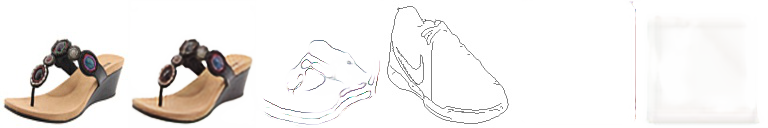

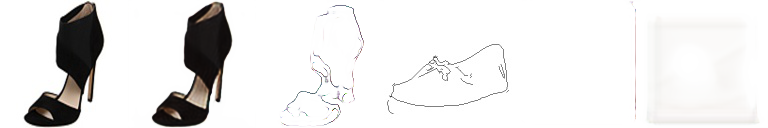

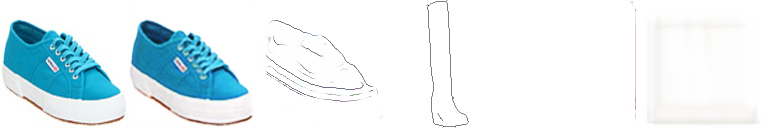

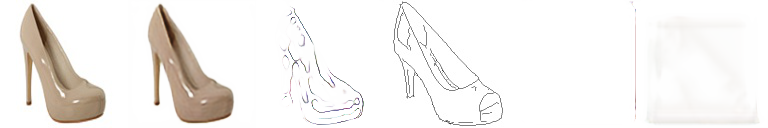

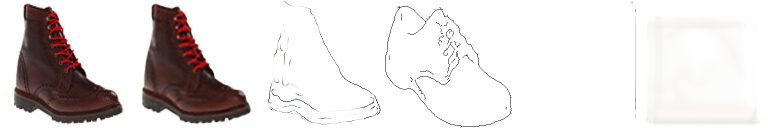

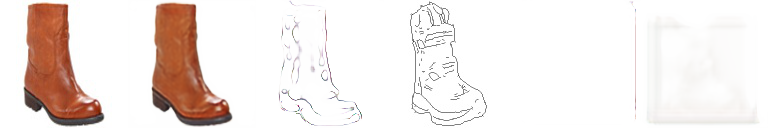

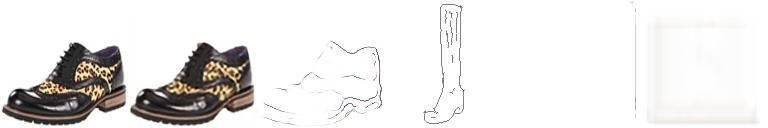

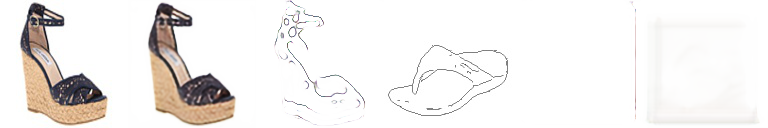

In [0]:
t0 = time.time()
gen_iterations = 0
errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 300

# ========== Change TOTAL_ITERS to desired iterations  ==========
TOTAL_ITERS = 50000

while gen_iterations < TOTAL_ITERS: 
    imgs_A, _ = next(gA) 
    imgs_A = imgs_A*2 - 1
    imgs_B, _ = next(gB) 
    imgs_B = imgs_B*2 - 1
        
    
    # Train dicriminators for one batch
    if gen_iterations % 1 == 0:
        errDA  = netDA_train([imgs_A, imgs_B])
        errDB  = netDB_train([imgs_B, imgs_A])
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]
    
    if gen_iterations == 5:
        print ("working.")

    # Train generators for one batch
    errGA = netGA_train([imgs_A, imgs_A, imgs_B])
    errGB = netGB_train([imgs_B, imgs_B, imgs_A])
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    gen_iterations+=1
    
    if gen_iterations % display_iters == 0:
        if gen_iterations % (display_iters) == 0: # clear_output every display_iters iters
            clear_output()
        #show_loss_config(loss_config)
        print('[Iter. %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters, errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        
        # get new batch of images and generate results for visualization
        for i in range(8//batchSize):
            vis_A, _ = gA.send(batchSize) 
            vis_A = vis_A*2 - 1
            vis_B, _ = gB.send(batchSize)
            vis_B = vis_B*2 - 1
            showG(vis_A, vis_B)          
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        
        # Save models
        encoder_style_A.save_weights("models/encoder_style_A.h5")
        encoder_content_A.save_weights("models/encoder_content_A.h5")
        encoder_style_B.save_weights("models/encoder_style_B.h5")
        encoder_content_B.save_weights("models/encoder_content_B.h5")
        decoder_A.save_weights("models/decoder_A.h5")
        decoder_B.save_weights("models/decoder_B.h5")
        netDA.save_weights("models/netDA.h5")
        netDB.save_weights("models/netDB.h5")